In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# CAM

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from constant import CSV_DIR, CLASS_NAMES
import numpy as np

from fastai.conv_learner import *
# import pixiedust
from matplotlib.patches import Rectangle
from datetime import datetime
import pandas as pd

import torch
import torchvision.transforms as transforms
from layers import *
from constant import CLASS_NAMES
from transform import chest_xray_transfrom
from metrics import *
import pretrainedmodels
from recorder import TrainingRecoder
import pretrainedmodels
from dataset import ChestXray14Dataset
from model_data import ModelData
from chexnet import ChexNet
import cv2


In [3]:
PATH = Path('/home/dattran/data/xray-thesis/chestX-ray14')
IMAGE_DN = 'images'
attention_dn = PATH/'tmp/attention'
attention_dn.mkdir(parents=True, exist_ok=True)

image_name = '00023325_019.png'
sz = 224

image_file = PATH/IMAGE_DN/image_name
chexnet = ChexNet(model_name='20180429-130928')

In [86]:
with open(PATH/'cut_all.pickle', 'rb') as f:
    d = pickle.load(f)
    
ratios = []
long_lung_names = []
normal_lung_names = []
short_lung_names = []
for k, v in d.items():
    coords = list(map(lambda x: int(x), v.split(' ')))
    w, h = coords[2] - coords[0], coords[3] - coords[1]
    ratio = w*1./h
    if ratio < 0.8: long_lung_names.append(k)
    elif ratio < 1.5: normal_lung_names.append(k)
    else: short_lung_names.append(k)
    ratios.append(ratio)
all_names = long_lung_names+normal_lung_names+short_lung_names

In [6]:
from constant import IMAGENET_MEAN, IMAGENET_STD
from heatmap import HeatmapGenerator

tfm = transforms.Compose([ 
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
                        ])

g = HeatmapGenerator(chexnet, mode='cam')

In [104]:
image_names = random.sample(all_names, 12)
image_names

['00011506_001.png',
 '00006642_042.png',
 '00017866_003.png',
 '00010007_017.png',
 '00027672_007.png',
 '00008892_003.png',
 '00002411_015.png',
 '00012628_043.png',
 '00016716_008.png',
 '00024850_000.png',
 '00007487_002.png',
 '00009188_001.png']

In [105]:
images = []
imgs = []
bbs = []
for i in range(12):
    image = Image.open(PATH/IMAGE_DN/image_names[i]).convert('RGB')
    images.append(image)
    coords = d[image_names[i]].split(' ')
    bb = list(map(lambda x: int(x), coords))
    bbs.append(bb)
    img = image.crop(bb)
    imgs.append(tfm(img))

image.crop()
imgs = torch.stack(imgs)
heatmaps, diseases = g.generate(imgs)

## Top 1

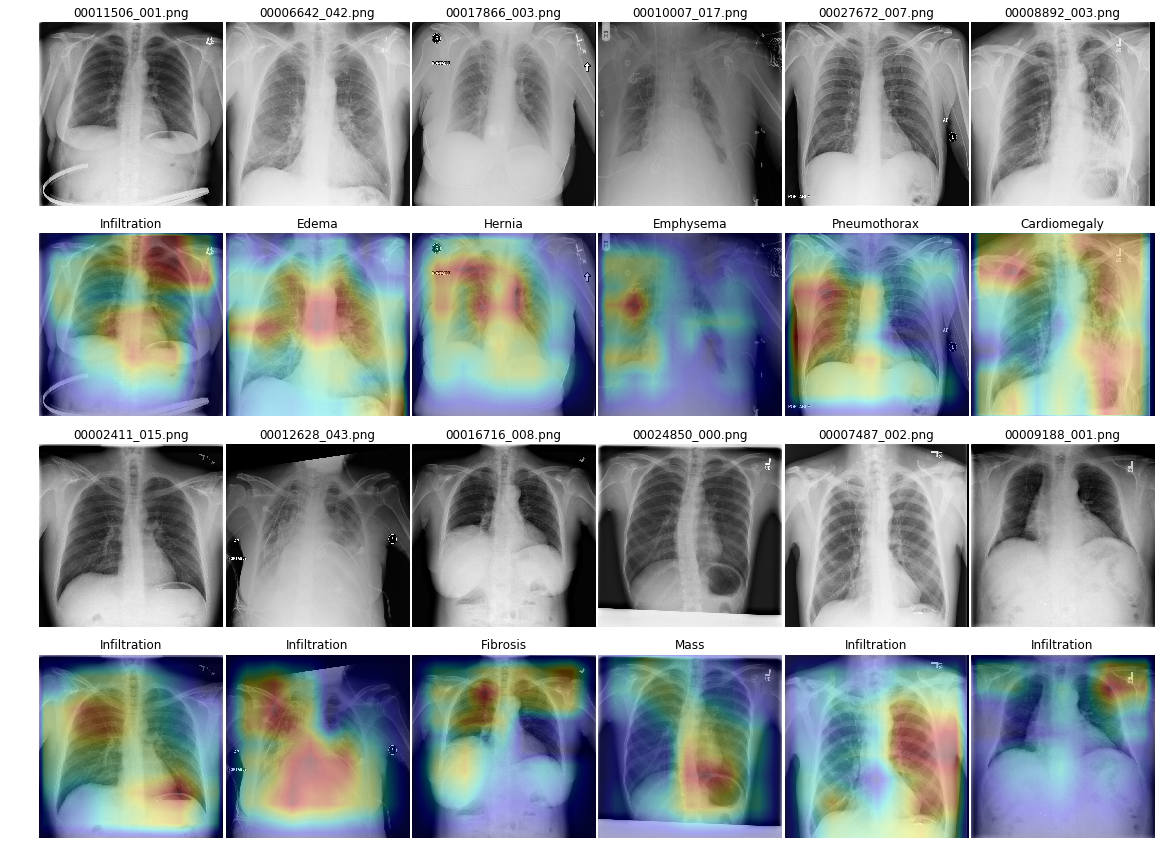

In [106]:
figs, axes = plt.subplots(4, 6, figsize=(20, 15))
axes = list(axes.flat)
for i in range(12):
# for i, ax in enumerate(axes.flat):
    image_id = i + (i>=6)*6
    cam_id = image_id + 6
    
    ax = axes[image_id]
    ax.imshow(images[i])
    ax.set_title(image_names[i]) # f'{}\n{}
    ax.set_axis_off()
    
    l, t, r, b = bbs[i]
    w, h = r-l, b-t
    heatmap = to_np(heatmaps[i])
    heatmap = cv2.resize(heatmap, (w, h))
    p_l, p_t = l, t
    p_r, p_b = 1024-r, 1024-b
    heatmap = np.pad(heatmap, ((p_t, p_b), (p_l, p_r)), mode='linear_ramp', end_values=0)
    
    ax = axes[cam_id]
    ax.set_title(diseases[i])
    ax.imshow(images[i])
    ax.imshow(heatmap, alpha=0.3, cmap='jet')
    ax.set_axis_off()
plt.subplots_adjust(wspace=0.01, hspace=0.15)
plt.savefig('cam_top_1.png')

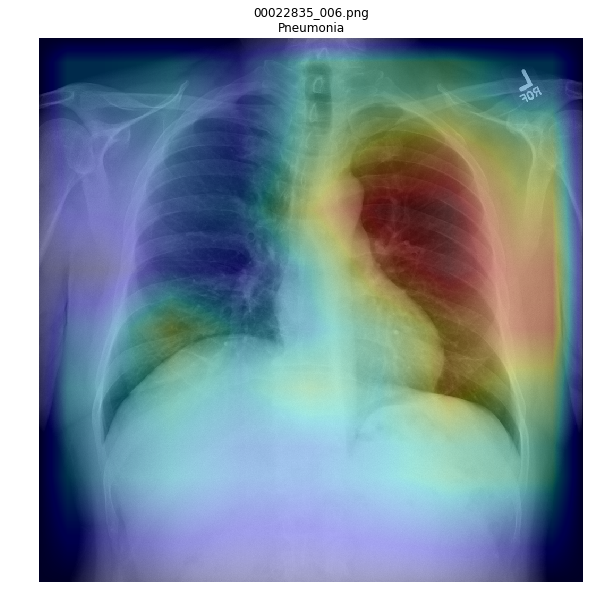

In [23]:
i = 11
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title(f'{image_names[i]}\n{diseases[i]}')
l, t, r, b = bbs[i]
w, h = r-l, b-t
heatmap = to_np(heatmaps[i])
heatmap = cv2.resize(heatmap, (w, h))
p_l, p_t = l, t
p_r, p_b = 1024-r, 1024-b
heatmap = np.pad(heatmap, ((p_t, p_b), (p_l, p_r)), mode='linear_ramp', end_values=0)
ax.imshow(images[i])
ax.imshow(heatmap, alpha=0.3, cmap='jet')
ax.set_axis_off()

# Attention

In [7]:
from scipy import ndimage
from matplotlib.patches import Rectangle
theta = 0.7

def plot_attention(image, heatmap, ax=None):
    """
    image (1024, 1024, 3)
    heatmap (7, 7)
    """
    if ax == None: ax = plt.subplot()
    heatmap = to_np(heatmap)
    heatmap = cv2.resize(heatmap, (1024, 1024))
    
    mask = heatmap > theta
    slice_y, slice_x = ndimage.find_objects(mask, True)[0]
    xy = (slice_x.start, slice_y.start)
    height = slice_y.stop - slice_y.start
    width= slice_x.stop - slice_x.start
    
    ax.imshow(image)
    ax.imshow(heatmap, alpha=0.4, cmap='jet')
    rect = Rectangle(xy, width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    

In [8]:
g = HeatmapGenerator(chexnet)

In [9]:
image = Image.open(image_file).convert('RGB')
heatmaps, diseases = g.generate(tfm(image)[None])

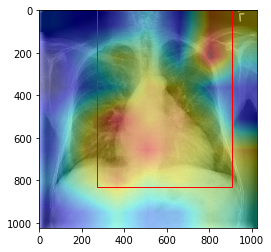

In [10]:
plot_attention(image, heatmaps[0])